In [1]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import json
import cv2
import math

from main_monodepth_pytorch import Model
%reload_ext autoreload
%autoreload 2

Check if CUDA is available

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

2

In [4]:
torch.cuda.empty_cache()

#### load ground truth and pifpaf data:

In [5]:
images_names=os.listdir('data/test/image_2/image_02/data/')
images_names.sort()

In [6]:
labels_names=os.listdir('data/scale_2_july/')
print(len(labels_names))

2567


In [7]:
labels_names.sort()

In [77]:
labels_names[1][:6]

'000005'

In [82]:
pifpafbox = []
for i, label in enumerate(labels_names):
    with open('data/pif_all/'+label) as inputfile:
        temp = json.load(inputfile)

        if temp != []:
            for person in temp:

                new=[x/2 for x in person['bbox']]
                keyp=[x/2 for x in person['keypoints']]

                confidence=sum(keyp[2::3])/(2*len(keyp[2::3]))
                del keyp[2::3]

                new.insert(0,int(label[:6]))
                new.extend(keyp)
                new.extend([confidence])

                pifpafbox.append(new)

print('we have',len(pifpafbox),'pifpaf pedestrians')

we have 8081 pifpaf pedestrians


In [83]:
final_boxes = np.array(pifpafbox)

#### we run the monodepth estimation algorithm on all the images

In [109]:
dict_parameters_test = edict({'data_dir':'data/test',
                              'model_path':'data/models/monodepth_resnet18_001.pth',
                              'output_directory':'data/output/',
                              'input_height':256,
                              'input_width':512,
                              'model':'resnet18_md',
                              'pretrained':True,
                              'mode':'test',
                              'device':'cuda:0',
                              'input_channels':3,
                              'num_workers':4,
                              'use_multiple_gpu':False})
model_test = Model(dict_parameters_test)

RuntimeError: CUDA error: out of memory

In [18]:
model_test.test()

Finished Testing


#### we load the outputed disparities matrices to estimate the depth

In [10]:
disp = np.load('data/output/disparities_pp.npy')  # Or disparities.npy for output without post-processing
disp.shape

(7481, 256, 512)

#### we estimate the depth of pedestrians from the area around the pifpaf keypoints

#### store estimation in txt files:

In [12]:
labels_names[0][:6]

'000000'

In [80]:
len(final_boxes)

8081

In [84]:
final_boxes[0]

array([0.00000000e+00, 7.22694778e+02, 1.63372215e+02, 7.90000000e+02,
       2.93319658e+02, 7.72800000e+02, 1.66300000e+02, 7.72650000e+02,
       1.63650000e+02, 7.71800000e+02, 1.63350000e+02, 7.59950000e+02,
       1.63900000e+02, 7.65300000e+02, 1.63450000e+02, 7.52400000e+02,
       1.80600000e+02, 7.59150000e+02, 1.82650000e+02, 7.45150000e+02,
       2.03300000e+02, 7.67500000e+02, 2.08500000e+02, 7.42150000e+02,
       2.24250000e+02, 7.90000000e+02, 2.18500000e+02, 7.62950000e+02,
       2.30900000e+02, 7.57600000e+02, 2.30400000e+02, 7.76400000e+02,
       2.58600000e+02, 7.43050000e+02, 2.60300000e+02, 7.88850000e+02,
       2.93300000e+02, 7.22700000e+02, 2.91150000e+02, 7.27941176e-01])

In [85]:
calib_path = 'calib/'

In [86]:
def get_calibration(path_txt):
    """Read calibration parameters from txt file:
    For the left color camera we use P2 which is K * [I|t]

    P = [fu, 0, x0, fu*t1-x0*t3
         0, fv, y0, fv*t2-y0*t3
         0, 0,  1,          t3]

    check also http://ksimek.github.io/2013/08/13/intrinsic/

    Simple case test:
    xyz = np.array([2, 3, 30, 1]).reshape(4, 1)
    xyz_2 = xyz[0:-1] + tt
    uv_temp = np.dot(kk, xyz_2)
    uv_1 = uv_temp / uv_temp[-1]
    kk_1 = np.linalg.inv(kk)
    xyz_temp2 = np.dot(kk_1, uv_1)
    xyz_new_2 = xyz_temp2 * xyz_2[2]
    xyz_fin_2 = xyz_new_2 - tt
    """

    with open(path_txt, "r") as ff:
        file = ff.readlines()
    p2_str = file[2].split()[1:]
    p2_list = [float(xx) for xx in p2_str]
    p2 = np.array(p2_list).reshape(3, 4)

    kk = p2[:, :-1]
    f_x = kk[0, 0]
    f_y = kk[1, 1]
    x0 = kk[2, 0]
    y0 = kk[2, 1]
    aa = p2[0, 3]
    bb = p2[1, 3]
    t3 = p2[2, 3]
    t1 = (aa - x0*t3) / f_x
    t2 = (bb - y0*t3) / f_y
    tt = np.array([t1, t2, t3]).reshape(3, 1)
    return kk, tt

In [87]:
def pixel_to_camera(uv1, kk, z_met):
    """
    (3,) array --> (3,) array
    Convert a point in pixel coordinate to absolute camera coordinates
    """

    kk_1 = np.linalg.inv(kk)
    xyz_met_norm = np.dot(kk_1, uv1)
    xyz_met = xyz_met_norm * z_met
    return xyz_met

In [36]:
matrix = get_calibration(calib_path + '000000'+'.txt')[0]
pixel_to_camera(np.array([(final_detections[0][1]+final_detections[0][3])/2,
                          (final_detections[0][2]+final_detections[0][4])/2, 1]),matrix, final_detections[0][-1])

NameError: name 'final_detections' is not defined

In [88]:
final_detections=[]
for box in final_boxes:
    disp_to_img = skimage.transform.resize(disp[int(box[0])].squeeze(), [375, 1242], mode='constant')
    depth = 0.54 * 721 / (1242 * disp_to_img)
    pred = []
    
    for joint in list(zip(box[5:-1][::2],box[5:-1][1::2])):
        
        if (((joint[1]+3)<depth.shape[0]) & ((joint[0]+3)<depth.shape[1])):
            for i in range(3):
                for j in range(3):
                    pred.append(depth[int(joint[1])+i,int(joint[0])+j])
                    pred.append(depth[int(joint[1])-i,int(joint[0])+j])
                    pred.append(depth[int(joint[1])+i,int(joint[0])-j])
                    pred.append(depth[int(joint[1])-i,int(joint[0])-j])
    
    pred=min(pred)
    
    filename = '0'*(6-len(str(int(box[0])))) + str(int(box[0]))
    
    matrix = get_calibration(calib_path + filename +'.txt')[0]
    pos = pixel_to_camera(np.array([(box[1]+box[3])/2,
                          (box[2]+box[4])/2, 1]),matrix, pred)
    
    final_detections.append(np.append(box,pos))
    #preds.append([int(box[0]), pred])
    #pred=sum(pred)/len(pred)
    
        
    #gtruth=box[-1]

    #errors.append([gtruth,pred,pred-gtruth,int(box[0])])


In [91]:
#final_boxes[0][1:5]
final_detections[1]

array([  5.        , 331.06335014, 185.59833288, 352.9647584 ,
       234.99495506, 343.95      , 186.7       , 344.8       ,
       185.65      , 343.05      , 185.6       , 346.45      ,
       185.85      , 341.15      , 186.05      , 349.7       ,
       191.85      , 338.45      , 191.45      , 352.5       ,
       200.95      , 333.9       , 199.35      , 352.95      ,
       209.65      , 331.05      , 207.15      , 347.25      ,
       209.6       , 339.9       , 209.45      , 345.7       ,
       220.85      , 341.        , 221.5       , 344.9       ,
       235.        , 347.15      , 232.55      ,   0.83529412,
        -7.62902784,   1.06767352,  20.57458052])

In [92]:
final_detections = np.array(final_detections)

In [93]:
for label in labels_names:
    f= open("data/final-pifpaf-2/"+label[:6]+".txt","w+")
    for i, box in enumerate(final_detections[final_detections[:,0]==int(label[:6])]):
        distance=0
        for item in box[1:5]:
            f.write(str(item))
            f.write(', ')
        f.write(str(box[-4]))
        f.write(', ')

        for item in box[-3:]:
            distance+=item**2
            
        f.write(str(math.sqrt(distance)))
        f.write('\n')
    f.close()

#### example of an image

In [48]:
np.sum(np.array(final_detections)[:,0]==image_id)

1

In [50]:
np.array(final_detections)[np.array(final_detections)[:,0]==image_id]

array([[  1.        , 331.06335014, 185.59833288, 352.9647584 ,
        234.99495506, 343.95      , 186.7       , 344.8       ,
        185.65      , 343.05      , 185.6       , 346.45      ,
        185.85      , 341.15      , 186.05      , 349.7       ,
        191.85      , 338.45      , 191.45      , 352.5       ,
        200.95      , 333.9       , 199.35      , 352.95      ,
        209.65      , 331.05      , 207.15      , 347.25      ,
        209.6       , 339.9       , 209.45      , 345.7       ,
        220.85      , 341.        , 221.5       , 344.9       ,
        235.        , 347.15      , 232.55      ,   0.83529412,
         -6.93669615,   0.97078251,  18.70744431]])

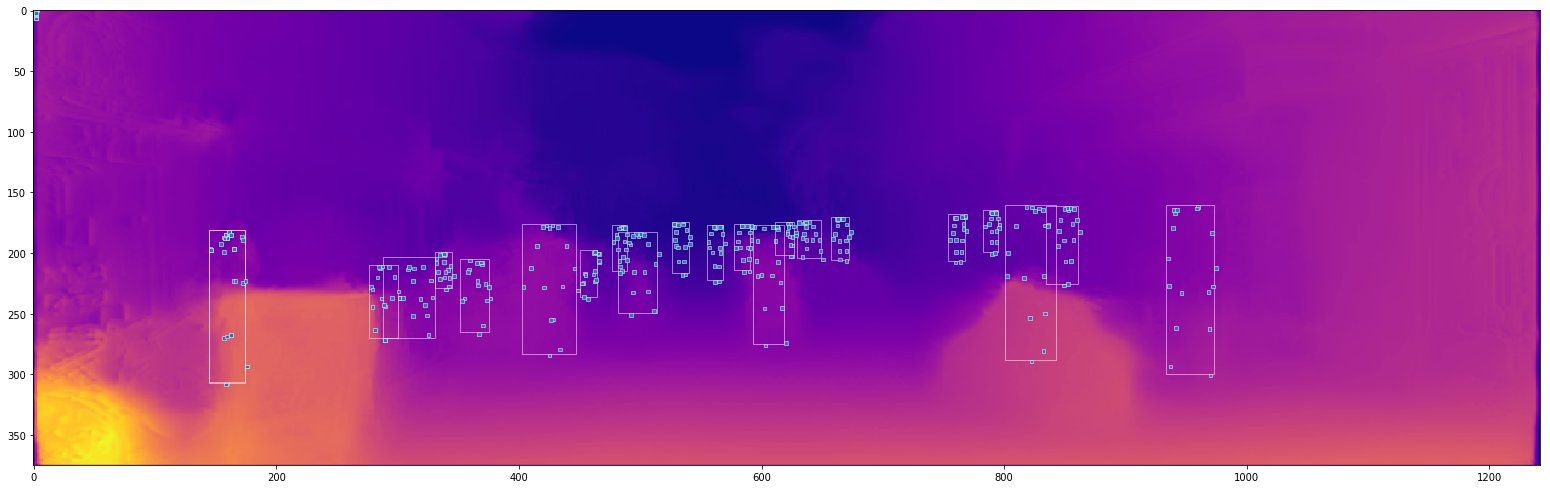

In [100]:
fig,ax = plt.subplots(figsize=(27, 10))

image_id=2282
disp_to_img = skimage.transform.resize(disp[image_id].squeeze(), [375, 1242], mode='constant')
ax.imshow(disp_to_img, cmap='plasma')

disp_bboxes = np.array(final_detections)[np.array(final_detections)[:,0]==image_id]
for disp_bbox in disp_bboxes:
    disp_bbox=list(disp_bbox)
    ax.add_patch(
                plt.Rectangle((disp_bbox[0+1], disp_bbox[1+1]),
                              disp_bbox[2+1] - disp_bbox[0+1],
                              disp_bbox[3+1] - disp_bbox[1+1],
                              fill=False, edgecolor='white',
                              linewidth=0.5, alpha=1))
    depth = 0.54 * 721 / (1242 * disp_to_img)

    #print('real distance is', errors[errors[:,-1]==image_id][0][1])

    for joint in list(zip(disp_bbox[5:-1][::2],disp_bbox[5:-1][1::2])):
        if ((joint[1]<depth.shape[0]) & (joint[0]<depth.shape[1])):
            ax.add_patch(
                plt.Rectangle(joint,
                              3,
                              3,
                              fill=True, edgecolor='white',
                              linewidth=0.5, alpha=1))

#print('estimated distance is',disp_bbox[-1])    
#print('error is', errors[errors[:,-1]==image_id][0][2])
plt.show()

In [19]:
from IPython.display import Image

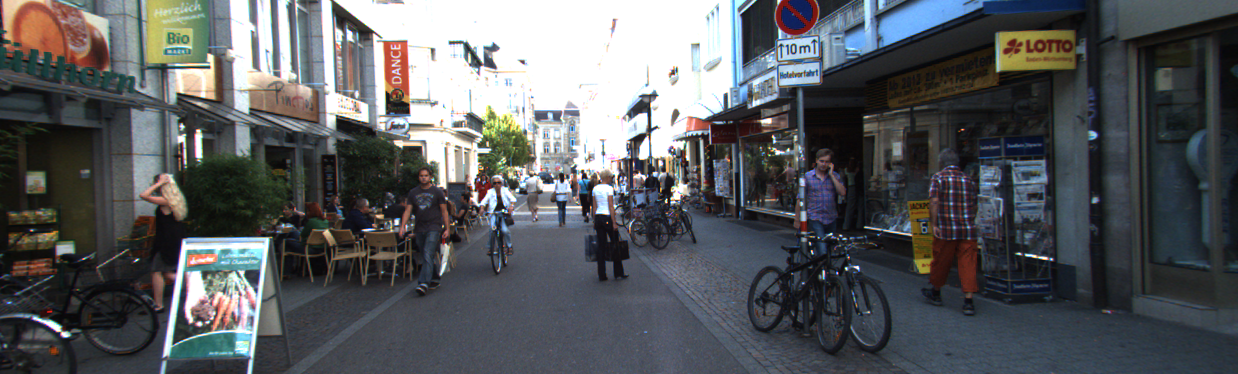

In [98]:
Image(filename = 'data/test/image_2/image_02/data/002282.png')